# Image classification using pytorch - tutorial

## 초기 설정

In [1]:
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchsummary

from matplotlib import pyplot as plt
import numpy as np

## 데이터 전처리

In [2]:
# 데이터 변형 함수
# Array -> Tensor로 변환 그리고 정규화

transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

transform

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [3]:
# 데이터 로드

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')                                

Files already downloaded and verified
Files already downloaded and verified


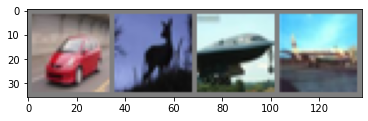

  car  deer plane plane


In [4]:
# 이미지 출력 함수
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
images.shape, torchvision.utils.make_grid(images).shape

(torch.Size([4, 3, 32, 32]), torch.Size([3, 36, 138]))

In [6]:
np.transpose(torchvision.utils.make_grid(images).numpy(), (1, 2, 0)).shape

(36, 138, 3)

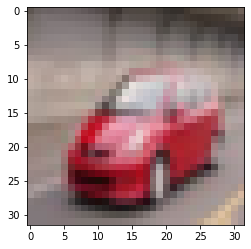

In [7]:
plt.imshow(np.transpose(images[0] / 2 + 0.5, (1, 2, 0)))
plt.show()

## 모델 학습 및 평가

In [9]:
# 모델 설정

# torch.nn.Module을 상속
# cpu() -> 파라미터를 cpu 버퍼로 이동
# cuda(device=None) -> 파라미터를 gpu 버퍼로 이동, 디바이스 지정 가능
# train() -> 학습 모드로 변경
# eval() -> 비학습 모드로 변경. dropout, batchnorm과 같은 학습에서만 필요한 과정 생략
class Net(nn.Module):
    # 해당 모델을 처음 초기화 할 때 해당 초기화 함수 실행
    def __init__(self):
        # CNN 2개, FC 3개로 구성
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # model(x)의 형태로 모델에 입력 데이터를 넣었을 때 동작
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# gpu사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = Net().to(device)

# 모델의 전체적인 모습을 보여주는 torchsummary 라이브러리
torchsummary.summary(net, images[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [22]:
EPOCHS = 2

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # inputs: (batch, channel, width, height)
        # labels: (class)
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 2000: 0.3f}')
            running_loss = 0.0

print('Finished Training')

[1, 2000] loss:  1.901
[1, 4000] loss:  1.598
[1, 6000] loss:  1.493
[1, 8000] loss:  1.444
[1, 10000] loss:  1.387
[1, 12000] loss:  1.323
[2, 2000] loss:  1.282
[2, 4000] loss:  1.252
[2, 6000] loss:  1.234
[2, 8000] loss:  1.234
[2, 10000] loss:  1.225
[2, 12000] loss:  1.204
Finished Training


In [24]:
torch.save(net.state_dict(), './saved/cifar_net.pth')

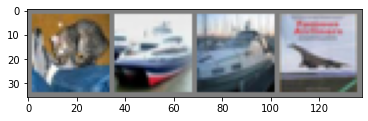

GroundTruth:    cat  ship  ship plane


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
net = Net()
net.load_state_dict(torch.load('./saved/cifar_net.pth'))

<All keys matched successfully>

In [26]:
outputs = net(images)

In [30]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane  ship


In [31]:
correct = 0
total = 0 

# 테스트 시에는 학습이 필요 없으므로 no_grad()
with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 57 %


In [46]:
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 56.0 %
Accuracy for class car   is: 55.7 %
Accuracy for class bird  is: 45.7 %
Accuracy for class cat   is: 26.1 %
Accuracy for class deer  is: 52.3 %
Accuracy for class dog   is: 58.1 %
Accuracy for class frog  is: 70.1 %
Accuracy for class horse is: 63.2 %
Accuracy for class ship  is: 70.4 %
Accuracy for class truck is: 73.9 %
